## **線形代数パッケージなどを読み込む**

In [1]:
using LinearAlgebra #線形代数パッケージ
using Combinatorics #組み合わせ順列を扱うパッケージ
using SparseArrays #疎行列を扱うパッケージ
using Arpack #大規模な固有値問題のためのパッケージ

## **Pauli 行列**

In [2]:
const σ⁰ = [
    1.0 0.0
    0.0 1.0
];

const σ¹ = [
    0.0 1.0
    1.0 0.0
];

const σ² = [
    0.0 -1.0im
    1.0im 0.0
];

const σ³ = [
    1.0 0.0
    0.0 -1.0
];

const σ⁺ = [
    0.0 1.0
    0.0 0.0
];

const σ⁻ = [
    0.0 0.0
    1.0 0.0
];

## **Jordan-Wigner 変換**

$$
\begin{align*}
c_k = (-\sigma^3_1) \otimes (-\sigma^3_2) \otimes \cdots \otimes (-\sigma^3_{k-1}) \otimes \sigma^-_k \otimes \sigma^0_{k+1} \otimes \cdots \otimes \sigma^0_{N} 
\end{align*}
$$
具体的な行列要素は
$$
\begin{align*}
(c_k)_{(i_1, \dots, i_N), (j_1, \dots, j_N)} = (-1)^{k-1} (-1)^{i_1 + i_2 + \cdots + i_{k-1}} \delta_{(i_1, \dots, i_{k-1}), (j_1, \dots, j_{k-1})} \delta_{(i_{k+1}, \dots, i_N), (j_{k+1}, \dots, j_N)} \delta_{i_k, 1} \delta_{j_k, 0}
\end{align*}
$$
で与えられる。ただし 添字は$i = 0, 1$を取るものとする。

In [3]:
function JordanWigner(num_sites::Integer, index::Integer)::Array{Real, 2}
    """
    Args:
        num_sites (Integer): the number of lattice sites
        index (Integer): lattice index
    Returns:
        Array{Float64, 2}
    """
    pauli_strings = [-σ³ for i in 1:index-1]
    append!(pauli_strings, [σ⁻]) # ! は破壊的処理(pythonで言うところの in_place = True) を意味する
    append!(pauli_strings, [σ⁰ for i in index+1:num_sites])
    return kron(pauli_strings...)
end;

function cop(num_modes::Integer, index::Integer)
    """
    Args:
        num_modes (Integer): the number of fermionic modes
        index (Integer): index for mode
    Returns:
        Array{Float64, 2}
    """
    dim = 2^num_modes
    cop_mat = spzeros(dim, dim) #ゼロで初期化
    base = reverse([2^i for i in 0:num_modes-1])
    for binary_str in Iterators.product(collect(Iterators.repeated([0 1], num_modes-1))...)
        binary_list = collect(binary_str)
        insert!(binary_list, index, 1) # [i_1 ... i_k=1 ... i_N]という Array の作成
        ind_left = dot(binary_list, base) + 1 # ２進数表記から整数へ変換(1から始まることに注意)
        binary_list[index] = 0 # [i_1 ... i_k=0 ... i_N] という Array の作成
        ind_right = dot(binary_list, base) + 1 # ２進数表記から整数へ変換(1から始まることに注意)
        sgn = sum(binary_list[1:index-1]) + index - 1 
        cop_mat[ind_left, ind_right] = (-1)^sgn　# 行列要素を代入
    end

    return cop_mat
end;

function cdg(num_modes::Integer, index::Integer)
    return cop(num_modes, index)'
end;

function nop(num_modes::Integer, index::Integer)
    return cdg(num_modes, index)*cop(num_modes, index)
end;

## 粒子数セクターを取り出すための関数

In [4]:
function get_index_from_ns(nlist::Array, num_sites::Integer)::Array{Integer, 1} #２進数表記した時に0の個数がnlistになるような整数のリストを返す
    """
    Args:
        nlist (Array): the number of sites per each internal degrees of freedom
        num_sites (Integer): the number of sites
    Returns:
        Array{Integer, 1}: list of indices
    Example:
        nlist=[2, 1], num_sites = 3 の時
        nlist[1] = 2 に対応する bitstring は [0, 0, 1], [0, 1, 0], [1, 0, 0]
        nlist[2] = 1 に対応する bitstring は [0, 1, 1], [1, 0, 1], [1, 1, 0]
        これらを交互に要素が並ぶように連結し、10進数の整数に変換:
        [0, 0, 1] + [0, 1, 1] = [0, 0, 0, 1, 1, 1] -> 7
    """
    l = size(nlist)[1]
    num_strings = l*num_sites
    base = reverse([2^i for i in 0:num_strings-1])
    binary_array = Array{Any}(nothing, l)
    for s in 1:l
        seed_vector = ones(Integer, num_sites)
        for i in 1:nlist[s]
            seed_vector[i] = 0
        end
        binary_array[s] = unique(permutations(seed_vector)) 
    end
    return_array = Integer[]
    for n_set in collect(Iterators.product(binary_array...))
        h = hcat(n_set...)'
        h = collect(Base.Flatten(h))
        append!(return_array, dot(h, base))
    end
    return return_array
end;

In [5]:
get_index_from_ns([2, 1], 3)

9-element Vector{Integer}:
  7
 13
 37
 19
 25
 49
 22
 28
 52

## **1次元鎖上の Fermi-Hubbard 模型**

In [6]:
function fermi_hubbard_model(num_sites::Integer, t::Number, onsite_interaction::Number; boundary_condition::String="open", particle_num::Union{Integer, Nothing}=nothing, nup::Union{Integer, Nothing}=nothing, ndown::Union{Integer, Nothing}=nothing)
    num_modes = 2*num_sites
    dim = 2^num_modes
    hop_ham = spzeros(dim, dim)
    for i in 1:num_sites-1
        hop_ham += t*(cdg(num_modes, 2*i-1)*cop(num_modes, 2*i+1) + cdg(num_modes, 2*i)*cop(num_modes, 2*i+2))
        hop_ham += conj(t)*(cdg(num_modes, 2*i+1)*cop(num_modes, 2*i-1)+ cdg(num_modes, 2*i+2)*cop(num_modes, 2*i))
        hop_ham += onsite_interaction*nop(num_modes, 2*i-1)*nop(num_modes, 2*i)
    end
    hop_ham += onsite_interaction*nop(num_modes, 2*num_sites-1)*nop(num_modes, 2*num_sites)

    if boundary_condition == "periodic" && num_sites > 2
        hop_ham += t*(cdg(num_modes, 2*num_sites-1)*cop(num_modes, 1) + cdg(num_modes, 2*num_sites)*cop(num_modes, 2))
        hop_ham += conj(t)*(cdg(num_modes, 1)*cop(num_modes, 2*num_sites-1) + cdg(num_modes, 2)*cop(num_modes, 2*num_sites))
    end

    if particle_num == nothing # particle_num が与えられない時はフルのハミルトニアンを返す
        return hop_ham
    else 
        if nup == nothing && ndown == nothing # nup, ndown を指定しないときは particle_num で指定されたセクターのハミルトニアンを返す
            indices = get_index_from_ns([particle_num], num_modes) .+ 1
            return hop_ham[indices, indices]
        elseif  typeof(nup) <: Integer && typeof(ndown) <: Integer #nup, ndown が指定された時は、それらで決まるセクターのハミルトニアンを返す
            if nup + ndown == particle_num
                indices = get_index_from_ns([nup, ndown], num_sites) .+ 1
                return hop_ham[indices, indices]
            else
                println("$(nup) + $(ndown) is not $(particle_num).")
            end
        else
            println("nup and ndown must be Integer or Nothing, simulataneously.")
        end
    end
end;

function lowest_energy(hamiltonian; sparse=true)::Real
    if sparse == true
        e, _ = eigs(hamiltonian, nev=1, which=:SR)
        return e[1]
    elseif sparse == false
        ham = Hermitian(Matrix(hamiltonian))
        e, _ = eigen(ham, 1:1)
        return e[1]
    end
end;

In [7]:
fermi_hubbard_model(2, -1.0, 1.0, particle_num=2, nup=1, ndown=1)

4×4 SparseMatrixCSC{Float64, Int64} with 10 stored entries:
  1.0  1.0  -1.0    ⋅ 
  1.0   ⋅     ⋅    1.0
 -1.0   ⋅     ⋅   -1.0
   ⋅   1.0  -1.0   1.0

## **対角化**

In [8]:
using Dates

In [9]:
start = Dates.now()
fhm_ham = fermi_hubbard_model(2, -1.0, 1.0, particle_num=2, nup=1, ndown=1)
energies, ψ = eigen(Matrix(fhm_ham))
elapsed_time = Dates.now() - start
println("elapsed_time is $(elapsed_time).")
println(energies)

elapsed_time is 612 milliseconds.
[-1.5615528128088272, 0.0, 1.000000000000002, 2.5615528128088303]


## 疎行列のまま解く

In [10]:
energies, ψ = eigs(fhm_ham, nev=3, which=:SR)
energies

3-element Vector{Float64}:
 -1.5615528128088298
 -1.021004766305735e-16
  1.0

## **基底エネルギーの相互作用のパラメータ依存性とプロット**

In [11]:
using Plots

In [12]:
function u_dependence(num_size::Integer, t::Number, umin::Real, umax::Real, length::Integer; boundary_condition::String="open", particle_num::Union{Integer, Nothing}=nothing, nup::Union{Integer, Nothing}=nothing, ndown::Union{Integer, Nothing}=nothing)::Array{Real, 1}
    energies = Real[]
    for onsite_interaction in range(umin, umax, length=length)
        fhm_ham = fermi_hubbard_model(
            num_size,
            t,
            onsite_interaction,
            boundary_condition=boundary_condition,
            particle_num=particle_num,
            nup=nup,
            ndown=ndown
        )
        e = lowest_energy(fhm_ham)
        append!(energies, e)
    end
    return energies
end;

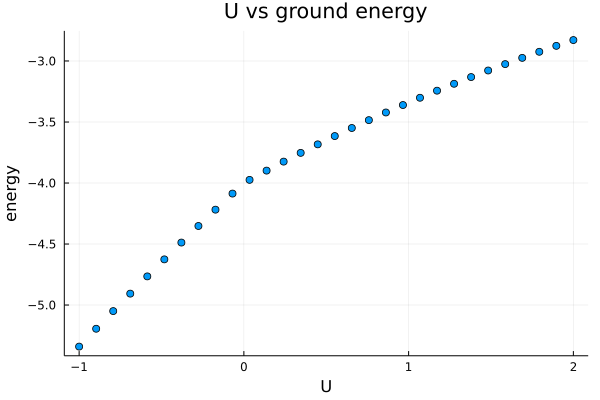

elapsed_time is 7089 milliseconds.


In [13]:
start = Dates.now()
num_size = 4
particle_num = 4
nup = 2
ndown = 2
t = -1.0
umin = -1.0
umax = 2.0
Δu = 0.1
length = Int(floor((umax - umin)/Δu))
u_list = collect(range(umin, umax, length=length))
energies = u_dependence(
    num_size,
    t,
    umin,
    umax,
    length,
    boundary_condition="periodic",
    particle_num=particle_num,
    nup=nup,
    ndown=ndown
)
energies = round.(energies, digits=8)
scatter(
    u_list,
    energies,
    title="U vs ground energy",
    xlabel="U", 
    ylabel="energy",
    label=""
)|> display
elapsed_time = Dates.now() - start
println("elapsed_time is $(elapsed_time).")